In [1]:
from common import colors, pvalue_thresholds, sbarlw

In [2]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..', '..'))
print os.getcwd()

/home/eharkin/projects/5HTGIF-dev


In [58]:
import warnings
import re
import copy
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.interpolate import griddata
from tqdm import tqdm, trange

from ezephys import pltools
from statannot import add_stat_annotation

from grr.Simulation import GIFnet_Simulation
from grr.GainEstimator import GainEstimator
from grr.Tools import raiseExpectedGot, timeToIndex, reprint
from grr.Spiketrain import PSTH
from grr.CurveFit import plot_linear_fit

In [4]:
plt.style.use(os.path.join('figs', 'scripts', 'writeup', 'publication_figure_style.dms'))
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'GIF_network')

In [5]:
DATA_PATH = os.path.join('data', 'simulations', 'GIF_network', 'deriv_input')

sim_dict = {'Baseline level': [], 'Rep': [], 'Model': []}

for baseline_level in ['-0.080', '-0.060', '-0.040', '-0.020', '0.000', '0.020', '0.040', '0.060', '0.080']:
    for fname in os.listdir(os.path.join(DATA_PATH, '{}_baseline'.format(baseline_level))):
        if fname.endswith(('hdf5', 'h5')):

            try:
                sim_dict['Model'].append(
                    GIFnet_Simulation(
                        os.path.join(DATA_PATH, '{}_baseline'.format(baseline_level), fname), 
                        mode = 'r'
                    )
                )
                sim_dict['Baseline level'].append(float(baseline_level))
                sim_dict['Rep'].append(
                    int(re.search(r'rep([0-9]+)', fname).groups()[-1])
                )
            except IOError:
                print('Problem with {} baseline {}'.format(baseline_level, fname))
                continue
            

sim_df = pd.DataFrame(sim_dict).sort_values(['Rep'])
sim_df.reset_index(inplace=True, drop=True)
sim_df.head()

,Baseline level,Model,Rep
0,-0.04,"[connectivity_matrix, gaba, ser]",0
1,0.04,"[connectivity_matrix, gaba, ser]",0
2,0.06,"[connectivity_matrix, gaba, ser]",0
3,-0.02,"[connectivity_matrix, gaba, ser]",0
4,0.08,"[connectivity_matrix, gaba, ser]",0


In [6]:
sim_df['Principal PSTH'] = None
sim_df['Principal PSTH'] = sim_df['Principal PSTH'].astype(object)
sim_df['GABA PSTH'] = None
sim_df['GABA PSTH'] = sim_df['GABA PSTH'].astype(object)

In [7]:
PSTH_width = 50.

for i in trange(sim_df.shape[0], desc='Model'):
    
    # Get PSTH from 5HT population.
    sim_df.at[i, 'Principal PSTH'] = np.empty((
        sim_df.loc[i, 'Model'].get_no_sweeps(), 
        sim_df.loc[i, 'Model'].get_no_timesteps()
    ))
    for sweep_no in trange(sim_df.loc[i, 'Model'].get_no_sweeps(), desc='5HT sweep', leave=False):
        sim_df.loc[i, 'Principal PSTH'][sweep_no, :] = PSTH(
            sim_df.loc[i, 'Model'].ser_spktrains[sweep_no, ...].sum(axis = 0),
            PSTH_width,
            sim_df.loc[i, 'Model'].get_no_ser_neurons()
        )
    
    # Get PSTHs from GABA population.
    sim_df.at[i, 'GABA PSTH'] = np.empty((
        sim_df.loc[i, 'Model'].get_no_sweeps(), 
        sim_df.loc[i, 'Model'].get_no_timesteps()
    ))
    for sweep_no in trange(sim_df.loc[i, 'Model'].get_no_sweeps(), desc='GABA sweep', leave=False):
        sim_df.loc[i, 'GABA PSTH'][sweep_no, :] = PSTH(
            sim_df.loc[i, 'Model'].gaba_spktrains[sweep_no, ...].sum(axis = 0),
            PSTH_width,
            sim_df.loc[i, 'Model'].get_no_gaba_neurons()
        )

print('\nDone!')

5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.80it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.10it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.12it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
Model:   3%|▎         | 6/180 [00:50<24:21,  8.40s/it]     


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.09it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
Model:   7%|▋         | 12/180 [01:40<23:25,  8.36s/it]    


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.09it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.02it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]
                                                          
Model:  10%|█         | 18/180 [02:30<22:15,  8.24s/it]    


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.02it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]
                                                          
Model:  13%|█▎        | 24/180 [03:20<21:34,  8.30s/it]    


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.14it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.30it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.02it/s]
                                                          
Model:  17%|█▋        | 30/180 [04:11<21:27,  8.59s/it]    


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.10it/s]
                                                          
Model:  20%|██        | 36/180 [05:01<20:00,  8.34s/it]    


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.10it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.02it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
Model:  23%|██▎       | 42/180 [05:51<19:18,  8.39s/it]    


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
Model:  27%|██▋       | 48/180 [06:41<18:26,  8.38s/it]    


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.96it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  3.97it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.10it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.97it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.02it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]
                                                          
Model:  30%|███       | 54/180 [07:31<17:30,  8.34s/it]    


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.02it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.01it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]
                                                          
Model:  33%|███▎      | 60/180 [08:21<16:35,  8.30s/it]    


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  3.97it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
Model:  37%|███▋      | 66/180 [09:11<15:57,  8.40s/it]    


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.02it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  3.99it/s]
                                                          
Model:  40%|████      | 72/180 [10:01<15:03,  8.37s/it]    


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.09it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
Model:  43%|████▎     | 78/180 [10:52<14:12,  8.36s/it]    


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.13it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.01it/s]
                                                          
Model:  47%|████▋     | 84/180 [11:41<13:18,  8.32s/it]    


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.09it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.00it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]
                                                          
Model:  50%|█████     | 90/180 [12:32<12:33,  8.37s/it]    


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.02it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.10it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.02it/s]
                                                          
Model:  53%|█████▎    | 96/180 [13:21<11:41,  8.35s/it]    


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  3.99it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.09it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.13it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
Model:  57%|█████▋    | 102/180 [14:11<10:47,  8.30s/it]   


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.09it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.02it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                                                          
Model:  60%|██████    | 108/180 [15:01<10:01,  8.36s/it]   


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  3.98it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.12it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]
                                                          
Model:  63%|██████▎   | 114/180 [15:51<09:07,  8.29s/it]   


5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  3.22it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.10it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                                                          
Model:  67%|██████▋   | 120/180 [16:43<08:22,  8.38s/it]   


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  4.00it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  4.02it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]
                                                          
Model:  70%|███████   | 126/180 [17:34<07:41,  8.55s/it]   


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.14it/s]
                                                          
Model:  73%|███████▎  | 132/180 [18:24<06:36,  8.27s/it]   


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
Model:  77%|███████▋  | 138/180 [19:14<05:50,  8.35s/it]   


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.14it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
Model:  80%|████████  | 144/180 [20:04<05:00,  8.35s/it]   


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                                                          
Model:  83%|████████▎ | 150/180 [20:54<04:09,  8.31s/it]   


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:05<00:00,  4.05it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                                                          
Model:  87%|████████▋ | 156/180 [21:45<03:22,  8.45s/it]   


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.02it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.10it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                                                          
Model:  90%|█████████ | 162/180 [22:35<02:29,  8.30s/it]   


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.12it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.07it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.10it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]
                                                          
Model:  93%|█████████▎| 168/180 [23:24<01:40,  8.33s/it]   


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.11it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.12it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.02it/s]
                                                          
Model:  97%|█████████▋| 174/180 [24:14<00:49,  8.32s/it]   


5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.00it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.04it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.02it/s]
                                                          
5HT sweep: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]
                                                          
Model: 100%|██████████| 180/180 [25:05<00:00,  8.36s/it]   


Done!


In [8]:
sim_df.head()

,Baseline level,Model,Rep,Principal PSTH,GABA PSTH
0,-0.04,"[connectivity_matrix, gaba, ser]",0,"[[0.16666666666666669, 0.16666666666666669, 0....","[[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0...."
1,0.04,"[connectivity_matrix, gaba, ser]",0,"[[1.7000000000000002, 1.7000000000000002, 1.73...","[[7.300000000000001, 7.300000000000001, 7.35, ..."
2,0.06,"[connectivity_matrix, gaba, ser]",0,"[[2.4, 2.433333333333333, 2.433333333333333, 2...","[[11.55, 11.55, 11.55, 11.55, 11.6000000000000..."
3,-0.02,"[connectivity_matrix, gaba, ser]",0,"[[0.16666666666666669, 0.16666666666666669, 0....","[[0.8500000000000001, 0.8500000000000001, 0.85..."
4,0.08,"[connectivity_matrix, gaba, ser]",0,"[[4.333333333333333, 4.433333333333334, 4.4333...","[[14.55, 14.55, 14.55, 14.55, 14.6000000000000..."


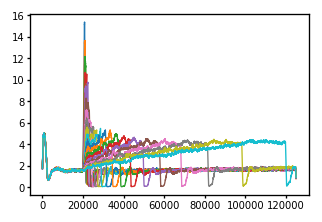

In [9]:
psths = []
for i, row in sim_df.loc[sim_df['Baseline level'] == 0.040, ['Rep', 'Principal PSTH', 'GABA PSTH']].iterrows():
    psths.append(row['Principal PSTH'].T)
    
psths = np.array(psths)

plt.plot(psths.mean(axis=0))

In [10]:
max_resp = np.empty((20, 4))
for i, baseline in enumerate(BASELINE_LEVELS):

    psths = []
    for j, row in sim_df.loc[sim_df['Baseline level'] == baseline, ['Rep', 'Principal PSTH', 'GABA PSTH']].iterrows():
        psths.append(row['Principal PSTH'])

    max_resp[:, i] = np.mean(psths, axis=0)[:, 19000:].max(axis=1)

max_resp = max_resp.T

NameError: name 'BASELINE_LEVELS' is not defined

In [32]:
BASELINE_LEVELS = np.array([-0.080, -0.060, -0.040, -0.020, 0, 0.020, 0.040, 0.060, 0.080])

max_resp = {key: np.empty((20, len(BASELINE_LEVELS))) for key in ['ser', 'som']}
max_resp_std = {key: np.empty((20, len(BASELINE_LEVELS))) for key in ['ser', 'som']}
for i, baseline in enumerate(BASELINE_LEVELS):

    psths = {key: [] for key in max_resp.keys()}
    for j, row in sim_df.loc[sim_df['Baseline level'] == baseline, ['Rep', 'Principal PSTH', 'GABA PSTH']].iterrows():
        psths['ser'].append(row['Principal PSTH'])
        psths['som'].append(row['GABA PSTH'])

    for key in max_resp:
        max_resp[key][:, i] = np.asarray(psths[key])[:, :, 19000:].max(axis=2).mean(axis=0)
        max_resp_std[key][:, i] = np.asarray(psths[key])[:, :, 19000:].max(axis=2).std(axis=0)

for key in max_resp:
    max_resp[key] = max_resp[key].T
    max_resp_std[key] = max_resp_std[key].T

In [33]:
deriv_in_pA_s = 100 / (np.logspace(np.log10(100), np.log10(1e4), 20) * 1e-3)

AttributeError: 'dict' object has no attribute 'ndim'

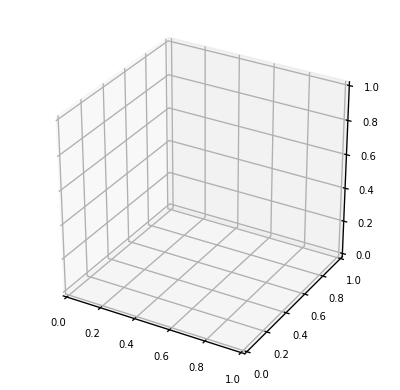

In [15]:
plt.figure(figsize=(4, 4))

ax = plt.subplot(111, projection='3d')
ax.plot_surface(
    X=np.broadcast_to(
        deriv_in_pA_s, (len(BASELINE_LEVELS), len(deriv_in_pA_s))
    ), 
    Y=np.broadcast_to(
        1e3 * np.asarray(BASELINE_LEVELS)[:, np.newaxis], 
        (len(BASELINE_LEVELS), len(deriv_in_pA_s))
    ), 
    Z=max_resp,
    cmap=plt.cm.coolwarm,
)
ax.invert_xaxis()
ax.set_yticks([-80, -40, 0, 40])
ax.set_xlabel('$dI/dt$ (pA/s)')
ax.set_ylabel('Baseline (pA)')
ax.set_zlabel('Peak firing rate (Hz/neuron)')

plt.tight_layout()
#plt.subplots_adjust(right=0.5, bottom=-0.1)


In [34]:
def interpolated_contour(x, y, Z, ax=None, **pltargs):
    if ax is None:
        ax = plt.gca()
        
    X, Y = np.meshgrid(x, y)
    X_interp, Y_interp = np.meshgrid(
        np.linspace(x.min(), x.max(), 30), 
        np.linspace(y.min(), y.max(), 50),
    )

    Z_interp = griddata(
        (X.flatten(), Y.flatten()), 
        Z.flatten(), 
        (X_interp.flatten(), Y_interp.flatten()),
        method='cubic'
    )
    Z_interp = np.clip(Z_interp.reshape(X_interp.shape), 0, np.inf)
    

    return ax.contourf(X_interp, Y_interp, Z_interp, 4, cmap=plt.cm.coolwarm, **pltargs)

In [81]:
sample_trace_model, sample_trace_psth = sim_df.loc[
    (sim_df['Baseline level'] == BASELINE_LEVELS[5]) & (sim_df['Rep'] == 0), ['Model', 'Principal PSTH']
].iloc[0, :]

In [59]:
with open(os.path.join(DATA_PATH, '0.020_baseline', 'input.dat'), 'rb') as f:
    input_arr = pickle.load(f)
    f.close()

In [98]:
SWEEPS_TO_SHOW = [0, 5, 10]
TIME_SLICE = slice(19000, 35000)
TIME_VEC = np.arange(0, TIME_SLICE.stop - TIME_SLICE.start) * input_arr['metaparams']['dt'] * 1e-3

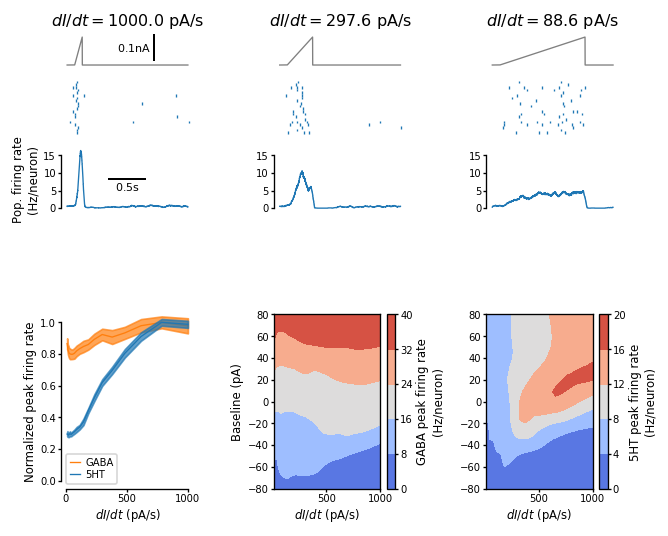

In [129]:
fig = plt.figure(figsize=(6, 5))

spec = gs.GridSpec(2, 3, hspace=0.6, wspace=0.6)

for i, sweep in enumerate(SWEEPS_TO_SHOW):
    ax = plt.subplot(spec[0, i])
    
    trace_spec = gs.GridSpecFromSubplotSpec(3, 3, spec[0, i], height_ratios=[0.5, 1, 1])
    
    plt.subplot(trace_spec[0, :])
    plt.title('$dI/dt = {:.1f}$ pA/s'.format(1e3 * input_arr['metaparams']['deriv_in_nA_s'][sweep]))
    plt.plot(TIME_VEC, input_arr['ser_input'][sweep, 0, TIME_SLICE].T, color=colors['input'])
    if i == 0:
        pltools.add_scalebar(
            y_size=0.1,
            y_units='nA',
            omit_x=True,
            round=False,
            anchor=(0.7, 0.1),
            linewidth=sbarlw
        )
    else:
        pltools.hide_border()
        pltools.hide_ticks()
    
    plt.subplot(trace_spec[1, :])
    plt.eventplot(
        [np.where(sample_trace_model.ser_spktrains[sweep, j, TIME_SLICE])[0] * 0.1 * 1e-3 for j in range(20)],
        color=colors['ser']
    )
    plt.xlim(0, TIME_VEC[-1])
    pltools.hide_ticks()
    pltools.hide_border('a')
    
    plt.subplot(trace_spec[2, :])
    plt.plot(TIME_VEC, sample_trace_psth[sweep, TIME_SLICE].T, color=colors['ser'])
    plt.ylim(-0.5, 17)
    plt.yticks([0, 5, 10, 15])
    if i == 0:
        plt.ylabel('Pop. firing rate\n(Hz/neuron)')
        pltools.add_scalebar(
            x_size=0.5, 
            x_units='s', 
            anchor=(0.7, 0.5), 
            round=False, 
            omit_y=True, 
            remove_frame=False,
            linewidth=sbarlw
        )
    pltools.hide_border('trb', trim=True)



plt.subplot(spec[1, 0])
for i, (label, key) in enumerate(zip(['GABA', '5HT'], ['som', 'ser'])):
    def normalize(x):
        return x / max_resp[key][5, :].max()
    
    plt.fill_between(
        deriv_in_pA_s,
        normalize(max_resp[key][5, :] - max_resp_std[key][5, :]),
        normalize(max_resp[key][5, :] + max_resp_std[key][5, :]),
        color=colors[key],
        alpha=0.7,
        zorder=i
    )
    plt.plot(
        deriv_in_pA_s, 
        normalize(max_resp[key][5, :]), 
        color=colors[key], 
        label=label,
        zorder=i
    )
plt.legend()
plt.ylim(-0.05, 1.05)
plt.xlabel('$dI/dt$ (pA/s)')
plt.ylabel('Normalized peak firing rate')
pltools.hide_border('tr', trim=True)


som_ax = plt.subplot(spec[1, 1])
som_cbar = fig.colorbar(
    interpolated_contour(
        deriv_in_pA_s, 
        1e3 * BASELINE_LEVELS, 
        max_resp['som'], 
        ax=som_ax,
        levels=np.linspace(0, 40, 6)
    )
)
som_cbar.ax.set_ylabel('GABA peak firing rate\n(Hz/neuron)')
som_ax.set_ylabel('Baseline (pA)')
som_ax.set_xlabel('$dI/dt$ (pA/s)')


raw_ax = plt.subplot(spec[1, 2])
raw_cbar = fig.colorbar(
    interpolated_contour(
        deriv_in_pA_s, 
        1e3 * BASELINE_LEVELS, 
        max_resp['ser'], 
        ax=raw_ax, 
        levels=np.linspace(0, 20, 6)
    )
)
raw_cbar.ax.set_ylabel('5HT peak firing rate\n(Hz/neuron)')
#raw_ax.set_ylabel('Baseline (pA)')
raw_ax.set_xlabel('$dI/dt$ (pA/s)')

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'derivative_filter.png'), bbox_inches='tight')
    plt.savefig(os.path.join(IMG_PATH, 'derivative_filter.svg'), bbox_inches='tight')